,class,count
0,Amphiprion_clarkii,4049
1,Chaetodon_lunulatus,2534
2,Chromis_chrysura,3593
3,Dascyllus_reticulatus,12112
4,Plectroglyphidodon_dickii,2683


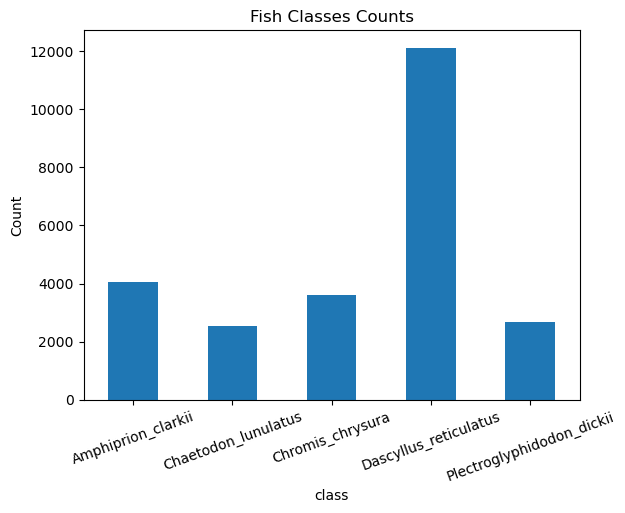

In [1]:
import os
import pandas as pd

#Show Data Distribution
p = r"./dataset"
classes = os.listdir(p)

df = pd.DataFrame(columns=["class","count"])

for i in range(0,len(classes)):
    df.loc[i] = [classes[i]] + [len(os.listdir(p+"/"+classes[i]))]
    
display(df)
ax = df.plot.bar(x='class', y='count', rot=20,title = "Fish Classes Counts", ylabel = "Count", legend = 0)

(83, 88, 3)
(77, 84, 3)
(71, 71, 3)
(112, 104, 3)
(173, 240, 3)


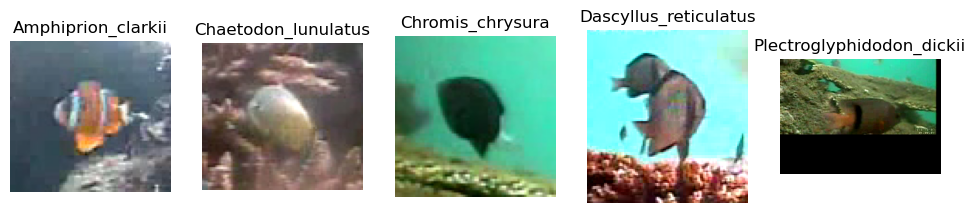

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#Show one of each class
plt.figure(figsize=(12, 6))
for i in range(0,len(classes)):
    plt.subplot(1,len(classes),i+1)
    image = mpimg.imread(p+ "/" + classes[i] + "/" + (os.listdir(p+"/"+classes[i])[0]))
    print(image.shape)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis('off')

In [3]:
############################################################
#Create text file with labels

#imPath_df = pd.DataFrame(columns=["path","class"])
############################################################

#Generate pandas df with paths and labels

# dfInd = 0
# for i in range(0,len(classes)):
#     imList = os.listdir(p+"/"+classes[i])
#     for j in range(0,len(imList)):
#         imPath_df.loc[dfInd] = [p+ "/" + classes[i] + "/" + str(imList[j])] + [i]
#         dfInd += 1

############################################################

# For generating text file
# with open('fish_labels.txt', 'w') as f:
#     for i in range(0,len(classes)):
#         imList = os.listdir(p+"/"+classes[i])
#         for j in range(0,len(imList)):
#             f.write(p+ "/" + classes[i] + "/" + str(imList[j]) + " " + str(i) + "\n")

############################################################

#For reading text file

imPath_df = pd.read_csv("fish_labels.txt",delim_whitespace=True, header=None, names = ["imP","label"])
print(len(imPath_df))

n_df = pd.DataFrame(columns=["imP","label"])

for i in range(0,5):
    new_imPath_df = imPath_df[imPath_df["label"]== i].iloc[:100]
    n_df = pd.concat([n_df,new_imPath_df])

#smaller dataset for testing
display(n_df)

24971


,imP,label
0,./dataset/Amphiprion_clarkii/fish_000000019599...,0
1,./dataset/Amphiprion_clarkii/fish_000000019599...,0
2,./dataset/Amphiprion_clarkii/fish_000000019599...,0
3,./dataset/Amphiprion_clarkii/fish_000000019599...,0
4,./dataset/Amphiprion_clarkii/fish_000000019599...,0
...,...,...
22383,./dataset/Plectroglyphidodon_dickii/fish_00001...,4
22384,./dataset/Plectroglyphidodon_dickii/fish_00001...,4
22385,./dataset/Plectroglyphidodon_dickii/fish_00001...,4
22386,./dataset/Plectroglyphidodon_dickii/fish_00001...,4


In [4]:
#https://stackoverflow.com/questions/75286974/build-tensorflow-dataset-of-images-from-path-list
import numpy as np
import skimage
from skimage.transform import resize

#converts list of paths to images
def path2im(p_array):
    return [resize((skimage.io.imread(x)),(64,64,3)) for x in p_array]

def process_labels(labels):
    l = tf.keras.utils.to_categorical(labels)
    return l

In [5]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#all class confusion matrix
def create_conf(class_df,gt, preds):
    #Show confusion matrix
    classLabels = np.unique(preds)
    the_matrix = confusion_matrix(preds, gt, labels=list(classLabels))

    names = np.unique(class_df['class'].values)

    df_cfm = pd.DataFrame(the_matrix, index = names, columns = names)
    plt.figure(figsize = (10,7))
    cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g',cbar=False, cmap = 'crest')
    cfm_plot.set_title("Fish Classification Confusion Matrix")
    cfm_plot.set_xlabel('Predicted')
    cfm_plot.set_ylabel('True Label')
    
    #per class confusion matrix
def display_class_conf(class_df,class_index,matrix):
    print(matrix)
    t_name = (np.unique(class_df['class'].values))[class_index] + " Confusion Matrix"
    df_cfm = pd.DataFrame(matrix,index = [1,0], columns = [0,1])
    sn.set(font_scale=2)
    cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g',cbar=False, cmap = 'crest')
    cfm_plot.set_title(t_name)

In [6]:
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from keras.layers import Dense, Conv2D, Flatten
from tqdm import tqdm



#data generator for configuring batch size
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, x_data, y_data, batch_size):
    self.x, self.y = x_data, y_data
    self.batch_size = batch_size
    self.num_batches = np.ceil(len(x_data) / batch_size)
    self.batch_idx = np.array_split(range(len(x_data)), self.num_batches)

  def __len__(self):
    return len(self.batch_idx)

  def __getitem__(self, idx):
    batch_x = self.x[self.batch_idx[idx]]
    batch_y = self.y[self.batch_idx[idx]]
    return batch_x, batch_y



In [7]:
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from keras.layers import Dense, Conv2D, Flatten
from tqdm import tqdm
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix

skf = StratifiedKFold(n_splits=2, shuffle = True, random_state = 123)

X=n_df.imP
y=n_df.label
y=y.astype('int') 


gt = [] #ground truth (appended on each fold)
results = [] # validation results (appended on each fold)
accs = [] # accuracy results (appended on each fold)


#stratified split
for train_index, test_index in tqdm(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values

    
    X_train_im = np.array(path2im(X_train))
    X_test_im = np.array(path2im(X_test))
    
    y_train = process_labels(y_train)
    y_test = process_labels(y_test)
    
    
    train_generator = DataGenerator(X_train_im, y_train, batch_size = 32)
    
    #create model
    model = tf.keras.models.Sequential()
    #add model layers
    model.add(tf.keras.Input(shape=(64,64,3)))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(5, activation='softmax'))
    
    
    #set optimiser
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(train_generator ,verbose=1, epochs=5)
    
    
    y_pred = model.predict(X_test_im)
    y_test = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1) #convert back from one-hot
    #add to arrays for confusion matrix
    accs.append(accuracy_score(y_test,y_pred))
    
    gt = np.append(gt , y_test)
    results = np.append(results , y_pred)
    
    
    
    #get confusion matrix by adding actual and predicted on each run

0it [00:00, ?it/s]

Epoch 1/5
8/8 [==============================] - 2s 22ms/step - loss: 1.9241 - accuracy: 0.0760
Epoch 2/5
8/8 [==============================] - 0s 4ms/step - loss: 1.5058 - accuracy: 0.4200
Epoch 3/5
8/8 [==============================] - 0s 4ms/step - loss: 1.3408 - accuracy: 0.5320
Epoch 4/5
8/8 [==============================] - 0s 4ms/step - loss: 1.1562 - accuracy: 0.5920
Epoch 5/5
8/8 [==============================] - 0s 7ms/step


1it [00:04,  4.11s/it]

Epoch 1/5
8/8 [==============================] - 0s 5ms/step - loss: 2.2138 - accuracy: 0.1160
Epoch 2/5
8/8 [==============================] - 0s 4ms/step - loss: 1.7019 - accuracy: 0.2000
Epoch 3/5
8/8 [==============================] - 0s 7ms/step - loss: 1.5640 - accuracy: 0.3240
Epoch 4/5
8/8 [==============================] - 0s 4ms/step - loss: 1.3972 - accuracy: 0.4040
Epoch 5/5
8/8 [==============================] - 0s 2ms/step


2it [00:05,  2.75s/it]


399 1 56 44
[[399   1]
 [ 56  44]]
337 63 8 92
[[337  63]
 [  8  92]]
372 28 10 90
[[372  28]
 [ 10  90]]
360 40 12 88
[[360  40]
 [ 12  88]]
395 5 51 49
[[395   5]
 [ 51  49]]
Accuracy: 0.726
Average Precision: 0.7857890873377478
Average Recall: 0.726
Average F1 Score 0.7124893426989307
Average Cohen K 274315.6349350991


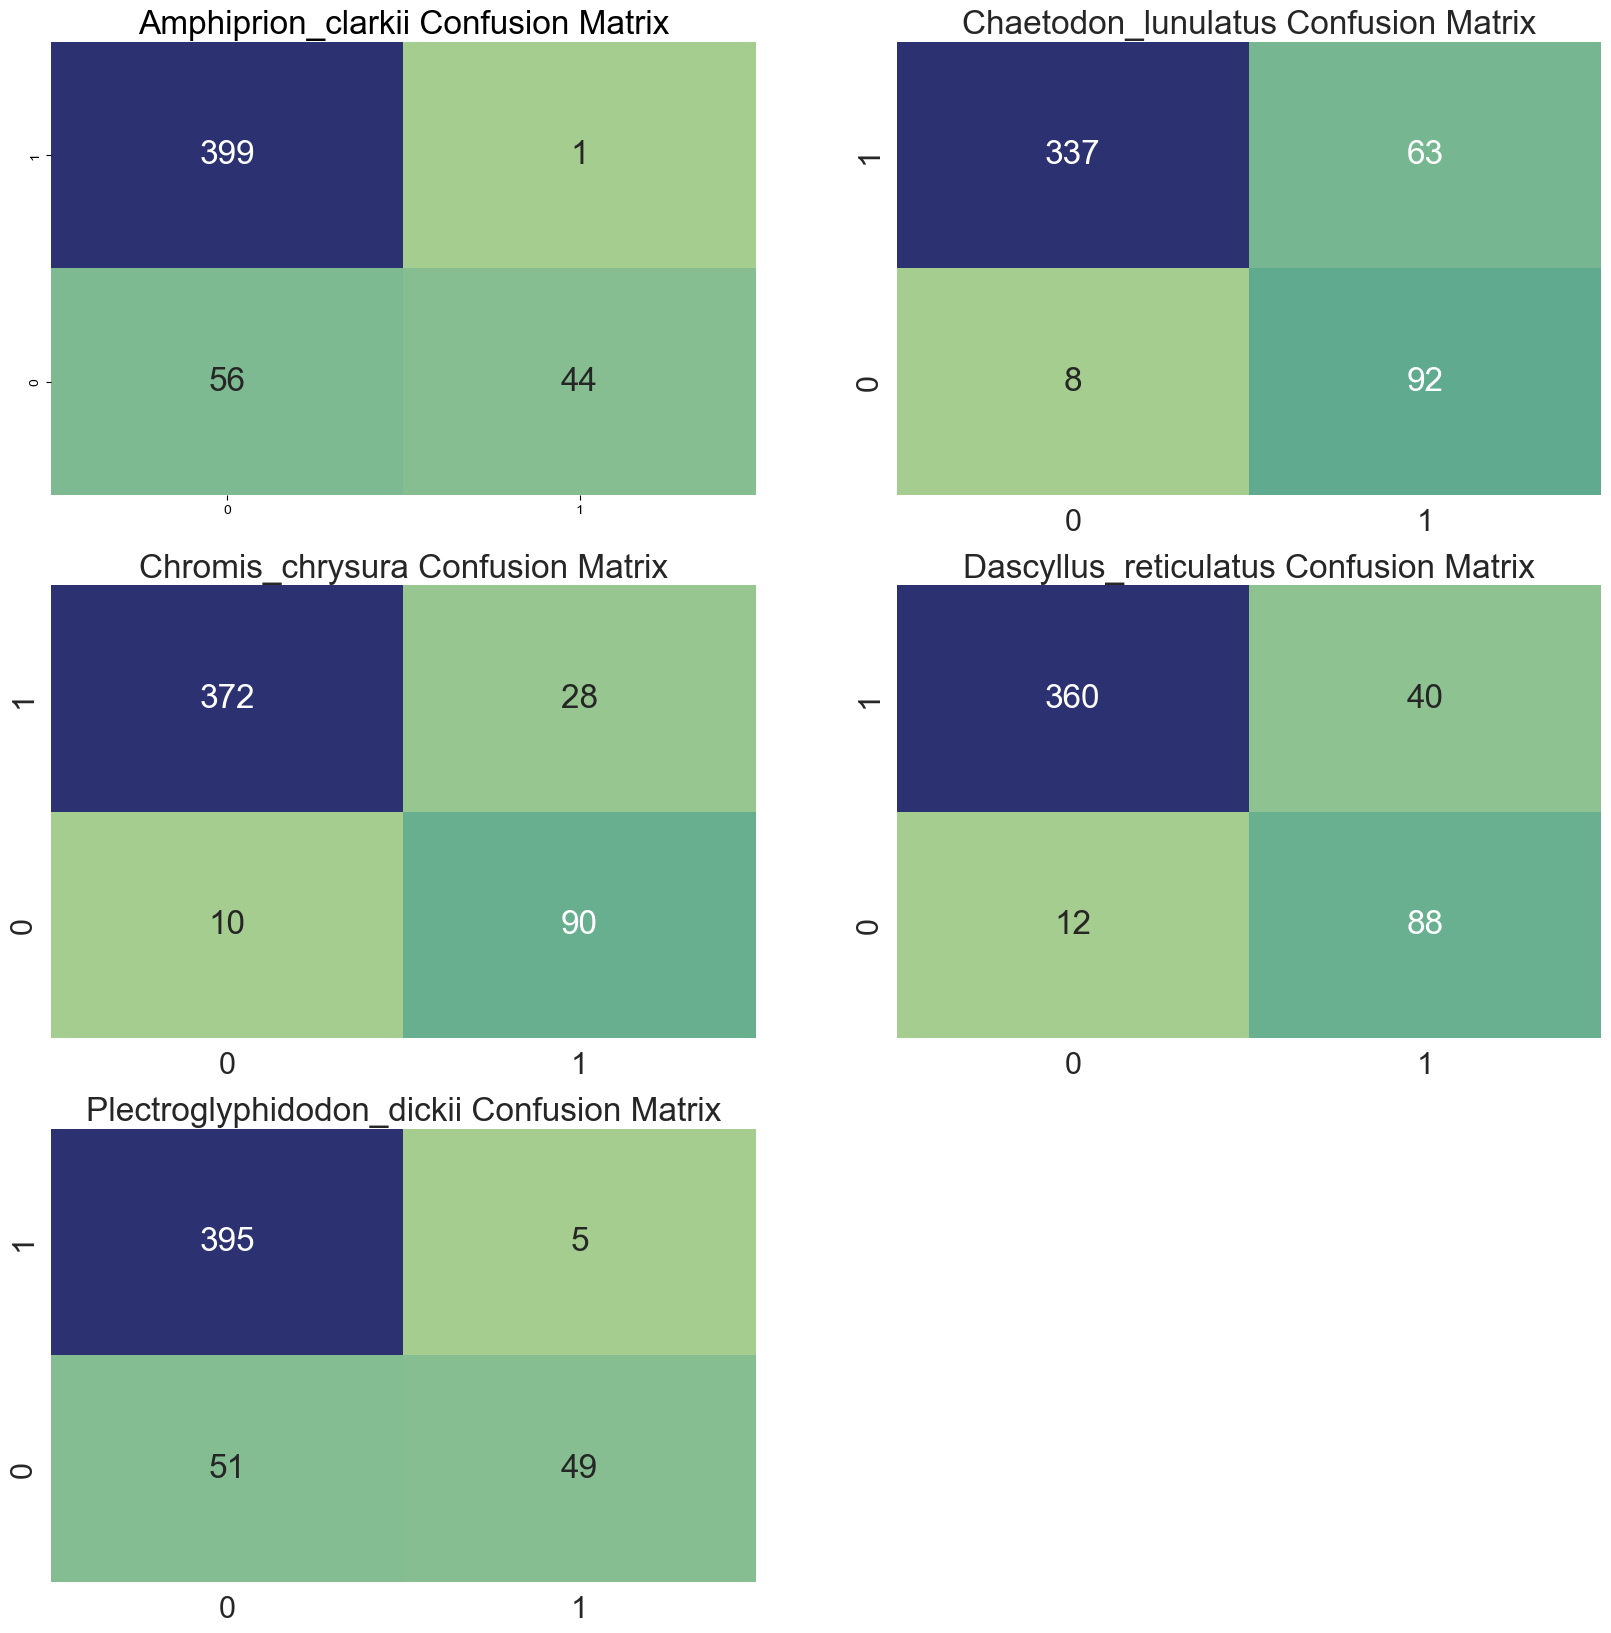

In [8]:
#get per class confusion matrix and calculate metrics

mcm = multilabel_confusion_matrix(gt, results, labels=[0,1,2,3,4])
Pre = []
Rec = []
F1 = []
CohenK = []

#calculate per class
plt.figure(figsize = (20,20))
plt.tight_layout()
for i, conf in enumerate(mcm):
    plt.subplot(3,2,i+1)
    tn, fp, fn, tp = conf.ravel() 
    print(tn, fp, fn, tp)
    pre = tp/(tp + fp)
    rec = tp/(tp + fn)
    f1 = (2*(pre*rec))/(pre+rec)
    coK = (2*((tp*tn) -(fp*fn))) / (tp+fp) * (fp+tn) + (tp+fn) *(fn+tn)
    
    Pre.append(pre)
    Rec.append(rec)
    F1.append(f1)
    CohenK.append(coK)
    display_class_conf(df, i, conf)


accuracy = accuracy_score(gt,results)
avPre = np.mean(Pre)
avRec = np.mean(Rec)
avF1 = np.mean(F1)
avCohenK = np.mean(CohenK)


#do per class confusion matrix

#add gridsearch
#gradcam?
#normalise?
#make table
pd
print("Accuracy:",accuracy)
print("Average Precision:",avPre)
print("Average Recall:",avRec)
print("Average F1 Score",avF1)
print("Average Cohen K", avCohenK)

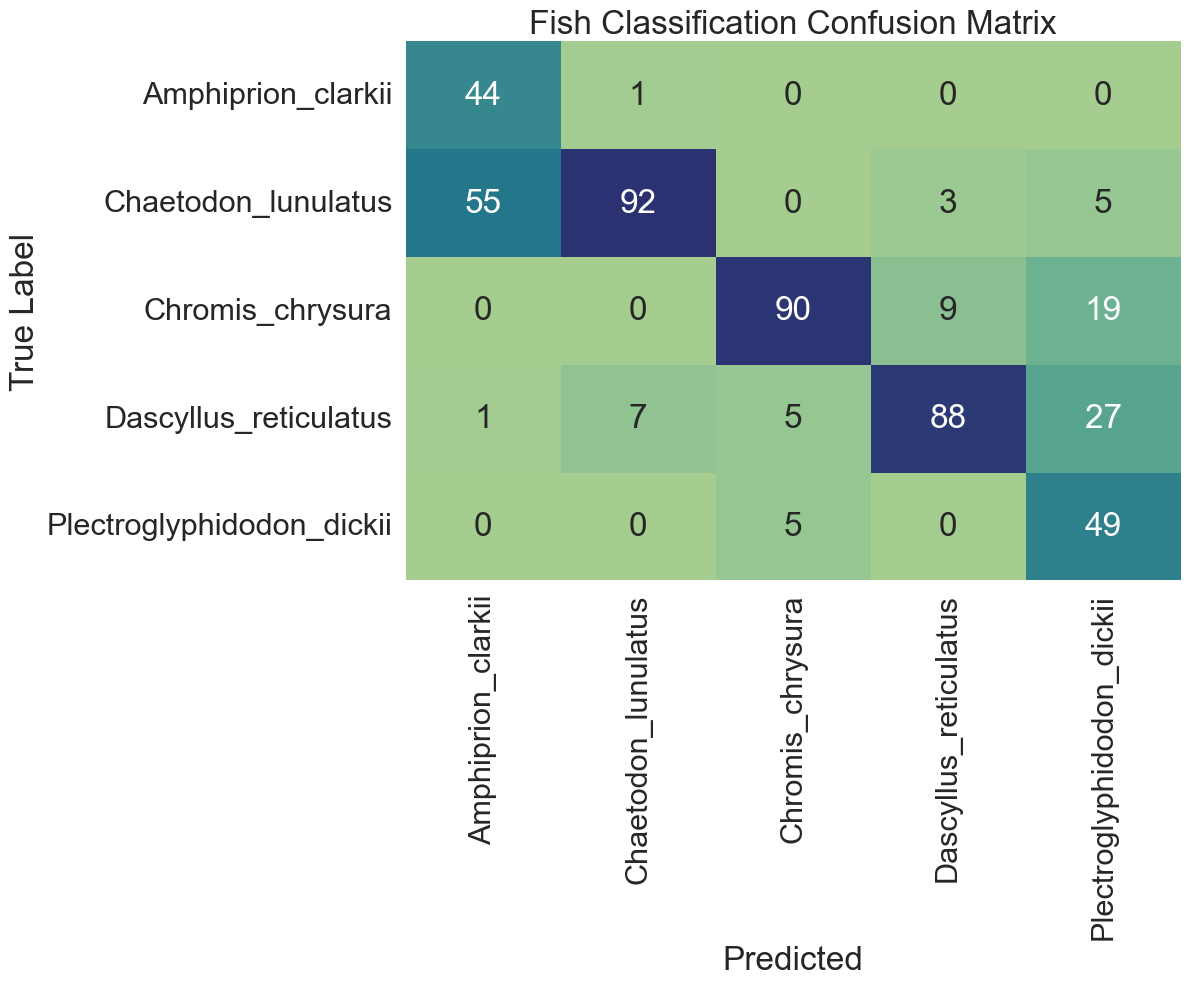

In [10]:
#Show confusion matrix
create_conf(df,gt,results)